# MNIST Pixel Entropy Analysis

This notebook computes the Shannon entropy for each pixel position in the MNIST training dataset.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent))

from mo_net.data import load_data
from mo_net.resources import MNIST_TRAIN_URL

MNIST_IMAGE_SIZE = 28
BIN_SIZE = 0.01

print(f"MNIST Image Size: {MNIST_IMAGE_SIZE}x{MNIST_IMAGE_SIZE}")
print(f"Bin size: {BIN_SIZE}")
print(f"Number of bins: {int(1.0 / BIN_SIZE) + 1}")


MNIST Image Size: 28x28
Bin size: 0.01
Number of bins: 101


In [17]:
print("Loading MNIST training data...")
X_train, Y_train = load_data(MNIST_TRAIN_URL, one_hot=False)

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {Y_train.shape}")
print(f"Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")

X_train_images = X_train.reshape(-1, MNIST_IMAGE_SIZE, MNIST_IMAGE_SIZE)
print(f"Reshaped images shape: {X_train_images.shape}")


2025-10-04 19:46:06.398 | INFO     | mo_net.data:load_data:137 - Loading data from s3://mo-net-resources/mnist_train.csv.


Loading MNIST training data...
Training data shape: (59999, 784)
Labels shape: (59999,)
Pixel value range: [0.000, 1.000]
Reshaped images shape: (59999, 28, 28)


In [ ]:
def bin_pixel_values(pixel_values, bin_size=0.01):
    return np.clip(np.floor(pixel_values / bin_size).astype(int), 0, int(1.0 / bin_size))

def compute_pixel_entropy(images, bin_size=0.01):
    _, height, width = images.shape
    
    entropy_map = np.zeros((height, width))
    
    print(f"Computing entropy for {height}x{width} pixels...")
    
    for i in range(height):
        for j in range(width):
            bin_indices = bin_pixel_values(images[:, i, j], bin_size)
            
            hist, _ = np.histogram(bin_indices, bins=int(1.0 / bin_size) + 1, range=(0, int(1.0 / bin_size) + 1), density=True)
            
            hist = (hist + 1e-10) / np.sum(hist + 1e-10)
            
            entropy_map[i, j] = -np.sum(hist * np.log(hist))
            
        if (i + 1) % 7 == 0:  # Progress indicator
            print(f"  Processed {i + 1}/{height} rows...")
    
    return entropy_map

print("Computing pixel entropy...")
pixel_entropy = compute_pixel_entropy(X_train_images, BIN_SIZE)

print(f"Entropy map shape: {pixel_entropy.shape}")
print(f"Entropy range: [{pixel_entropy.min():.3f}, {pixel_entropy.max():.3f}]")


Computing pixel entropy...
Computing entropy for 28x28 pixels...
  Processed 7/28 rows...
  Processed 14/28 rows...
  Processed 21/28 rows...
  Processed 28/28 rows...
Entropy map shape: (28, 28)
Entropy range: [0.000, 4.516]


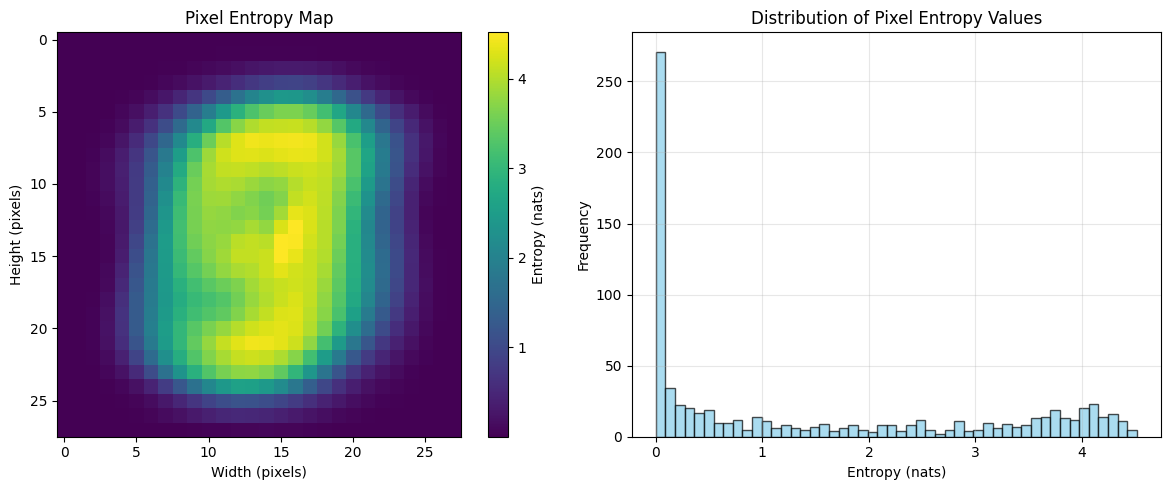

Statistics:
  Mean entropy: 1.4597 nats
  Std entropy: 1.6049 nats
  Min entropy: 0.0000 nats
  Max entropy: 4.5162 nats


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.colorbar(axes[0].imshow(pixel_entropy, cmap='viridis', aspect='equal'), ax=axes[0], label='Entropy (nats)')
axes[0].set_title('Pixel Entropy Map')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Height (pixels)')

axes[1].hist(pixel_entropy.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Distribution of Pixel Entropy Values')
axes[1].set_xlabel('Entropy (nats)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Statistics:")
print(f"  Mean entropy: {pixel_entropy.mean():.4f} nats")
print(f"  Std entropy: {pixel_entropy.std():.4f} nats")
print(f"  Min entropy: {pixel_entropy.min():.4f} nats")
print(f"  Max entropy: {pixel_entropy.max():.4f} nats")
